<a href="https://colab.research.google.com/github/wulanika/klasifikasi-4-jenis-sendok/blob/main/Klasifikasi_4_Jenis_Kelas_Sendok.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1. Install library
!pip install split-folders gdown

In [ ]:
# 2. Download dataset dari Google Drive via link (tanpa mount)
import gdown
import zipfile
import os

file_id = '14Ne047cR9Rnz7xMGya8ZJzGh9lDvWx1X'  # File ID dari Google Drive
gdown.download(f"https://drive.google.com/uc?id={file_id}", 'dataset.zip', quiet=False)

Downloading...
From: https://drive.google.com/uc?id=14Ne047cR9Rnz7xMGya8ZJzGh9lDvWx1X
To: /content/dataset.zip
100%|██████████| 20.8M/20.8M [00:00<00:00, 37.0MB/s]


'dataset.zip'

In [23]:
import shutil
import random
from pathlib import Path

# Path awal dataset setelah diekstrak
original_dataset_dir = Path("dataset/Dataset (resize)")

# Tujuan folder baru
base_dir = Path("dataset/split_dataset")
train_dir = base_dir / "train"
val_dir = base_dir / "val"
test_dir = base_dir / "test"

# Buat folder train, val, dan test
for folder in [train_dir, val_dir, test_dir]:
    folder.mkdir(parents=True, exist_ok=True)

# Rasio split
val_split = 0.2  # 20% untuk validasi
test_split = 0.1 # 10% untuk testing

# Untuk setiap kelas
for class_dir in original_dataset_dir.iterdir():
    if class_dir.is_dir():
        # Ambil semua file gambar dalam folder kelas
        images = list(class_dir.glob("*"))
        random.shuffle(images)

        class_name = class_dir.name

        # Hitung jumlah data
        total = len(images)
        val_count = int(total * val_split)
        test_count = int(total * test_split)
        train_count = total - val_count - test_count

        # Bagi dataset
        train_images = images[:train_count]
        val_images = images[train_count:train_count + val_count]
        test_images = images[train_count + val_count:]

        # Buat subfolder kelas di masing-masing folder tujuan
        for subset, subset_images in zip(
            [train_dir, val_dir, test_dir],
            [train_images, val_images, test_images]
        ):
            class_subset_dir = subset / class_name
            class_subset_dir.mkdir(parents=True, exist_ok=True)
            for img in subset_images:
                shutil.copy(img, class_subset_dir)

print("✅ Dataset berhasil di-split ke train, val, dan test.")


✅ Dataset berhasil di-split ke train, val, dan test.


In [24]:
# 3. Ekstrak dataset ZIP
with zipfile.ZipFile('dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('dataset')

In [25]:
# 5. Setup ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path yang benar
train_dir = '/content/dataset/split_dataset/train'
val_dir = '/content/dataset/split_dataset/val'
test_dir = '/content/dataset/split_dataset/test'

img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)


Found 1087 images belonging to 4 classes.
Found 430 images belonging to 4 classes.
Found 229 images belonging to 4 classes.


Found 1087 images belonging to 4 classes.
Found 430 images belonging to 4 classes.
Found 229 images belonging to 4 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 30s 658ms/step - accuracy: 0.2983 - loss: 1.5801 - val_accuracy: 0.3884 - val_loss: 1.4140
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 14s 417ms/step - accuracy: 0.3867 - loss: 1.3603 - val_accuracy: 0.4605 - val_loss: 1.2787
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 14s 416ms/step - accuracy: 0.4557 - loss: 1.2367 - val_accuracy: 0.5070 - val_loss: 1.1647
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 394ms/step - accuracy: 0.5039 - loss: 1.1883 - val_accuracy: 0.5465 - val_loss: 1.0752
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 396ms/step - accuracy: 0.5584 - loss: 1.0608 - val_accuracy: 0.5930 - val_loss: 1.0038
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 13s 397ms/step - accuracy: 0.5960 - loss: 0.9637 - val_accuracy: 0.6372 - val_loss: 0.9406
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 15s 435ms/step - accuracy: 0.6074 - loss: 0.9555 - val_accuracy: 0.6791 - val_loss: 0.8716
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 13s 392ms/step - accuracy: 0.6780 - loss: 0.8563 - val_accu

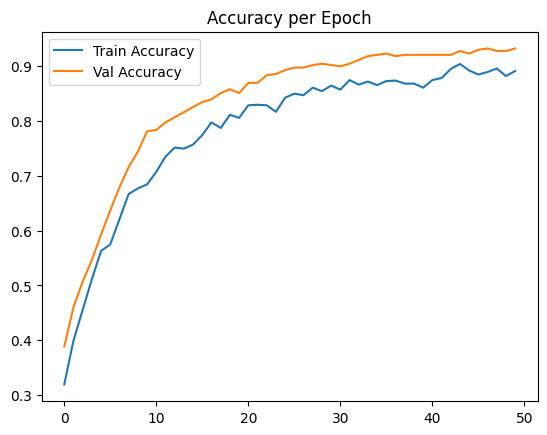

In [28]:
from keras.applications import MobileNetV2
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import Adam
import matplotlib.pyplot as plt

# Ukuran gambar dan batch
img_height, img_width = 224, 224
batch_size = 32

# Direktori dataset hasil split
base_dir = "dataset/split_dataset"

# Data Augmentation hanya untuk training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Data generators
train_generator = train_datagen.flow_from_directory(
    f"{base_dir}/train",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    f"{base_dir}/val",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    f"{base_dir}/test",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Model dengan MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze layer dasar
for layer in base_model.layers:
    layer.trainable = False

# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator
)

# Evaluasi di test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"📊 Akurasi Test: {test_acc:.2f}")

# Visualisasi akurasi dan loss
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()
plt.show()


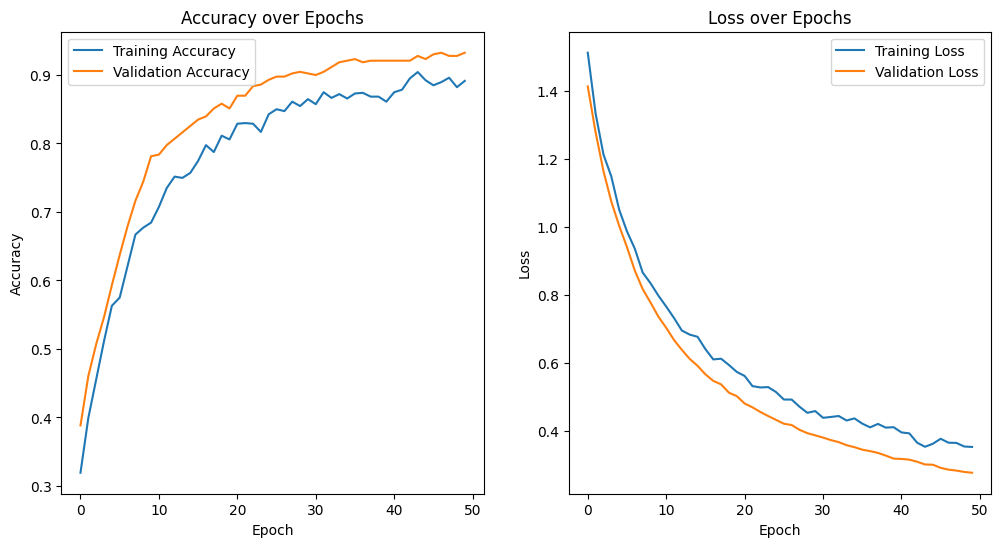

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step


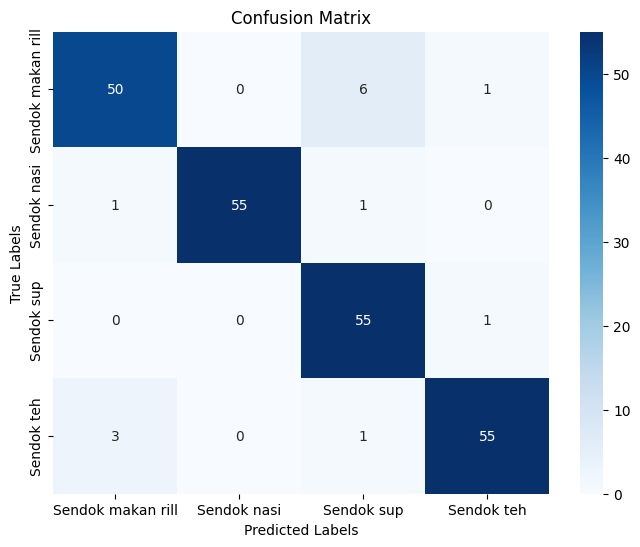

Classification Report:

                   precision    recall  f1-score   support

Sendok makan rill       0.93      0.88      0.90        57
      Sendok nasi       1.00      0.96      0.98        57
       Sendok sup       0.87      0.98      0.92        56
       Sendok teh       0.96      0.93      0.95        59

         accuracy                           0.94       229
        macro avg       0.94      0.94      0.94       229
     weighted avg       0.94      0.94      0.94       229



In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Visualisasi grafik akurasi dan loss
def plot_history(history):
    plt.figure(figsize=(12, 6))

    # Akurasi
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Tampilkan grafik history
plot_history(history)

# Prediksi data test
test_preds = model.predict(test_generator, verbose=1)
y_pred = np.argmax(test_preds, axis=1)
y_true = test_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
class_names = list(test_generator.class_indices.keys())

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification Report
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:\n")
print(report)
